# Feature Extraction & Clustering

## Copyright notice

This version (c) 2020 Fabian Offert, [MIT License](LICENSE).

## Colab setup

Only run this cell if you are running this notebook via Google Colab!

In [ ]:
!wget https://zentralwerkstatt.org/files/wga.zip
!unzip wga.zip
import sys
!git clone https://github.com/zentralwerkstatt/HUJI
!pip install lap
sys.path.append('HUJI/lib/')

## Imports

We are using the PyTorch as our deep learning framework.

In [16]:
import sys
sys.path.append('lib/')
from vc_toolbox import *

import numpy as np

import torch as t
import torchvision as tv
import torch.nn as nn

Read image files in our dataset.

In [2]:
folder = 'wga' # Relative path
img_files = get_all_files(folder, extension='.jpg')
print(f'{len(img_files)} files found')

2200 files found


## Extract features

We will use the VGG architecture in our experiments from now on (here VGG19). We will import a fully-trained model trained on the ImageNet dataset. The architecture requires that we resize our input images to 224x224 pixels first, which we accomplish by using `tv.transforms`. As our *feature vector*, we will use the *first fully connected layer* of VGG19 which has 4096 dimensions.

First, however, we need to check if we have a GPU with CUDA at our disposal.

In [15]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
img_size = 224
feature_size = 4096 # VGG19 fc1
preprocess = tv.transforms.Compose([tv.transforms.Resize((img_size, img_size)), tv.transforms.ToTensor()])
extractor = tv.models.vgg19(pretrained=True).to(device) # Load the model and move to the GPU, if available
print(extractor) # Show the model architecture
extractor.classifier = nn.Sequential(*list(extractor.classifier.children())[:5]) # VGG19 fc1
extractor.eval() # Set model to evaluation mode, we are not training anything

This is our feature extractor function. It simply loads an image file, pushes it through the network and returns the values of fc1 as a numpy matrix (of, logically, size 4096).

In [5]:
def get_features(file):
    img = load_img(file) # Some images are b/w so always convert to RGB (color)
    input = preprocess(img).unsqueeze(0).to(device) # Prepare image for network
    tensor = extractor.forward(input) # Push image through network
    tensor = tensor.data.squeeze() # Remove batch dimension from result
    features = tensor.cpu().numpy() # Move to CPU, if on GPU, and convert to NumPy matrix
    return features # Return to calling function

Now we can extract the fatures for *all* our images!

In [6]:
features = np.zeros((len(img_files), feature_size))
for i, file in enumerate(img_files):
    features[i] = get_features(file)

Let's peek into the results:

In [7]:
print(features.shape)

(2200, 4096)


Now to the most important part: dimensionality reduction. We will use the pretty recent UMAP algorithm to reduce our array down from 4096 dimensions to just 2: this way we can plot each datapoint in Euclidian space. UMAP, and related algorithms like T-SNE and PCA, are very good at *preserving relations between datapoints*. Thus, while a 2D-plot of our feature vectors is not a faithful and complete *visualization*, it is the best possible *approximation* in human-legible terms. Thankfully, with the `umap-learn` library, dimensionality reduction is fast and done in one line, even for very large datasets, like the MoMA dataset.

In [8]:
reducer = umap.UMAP()
features_UMAP = reducer.fit_transform(features)
# Normalize to 0,1
features_UMAP -= features_UMAP.min(axis=0)
features_UMAP /= features_UMAP.max(axis=0)

In [9]:
print(features_UMAP.shape)

(2200, 2)


## Plot images

Now we can plot our dataset. The provided function also produces an HTML map for us to further explore the visualization.

Canvas size: 3008


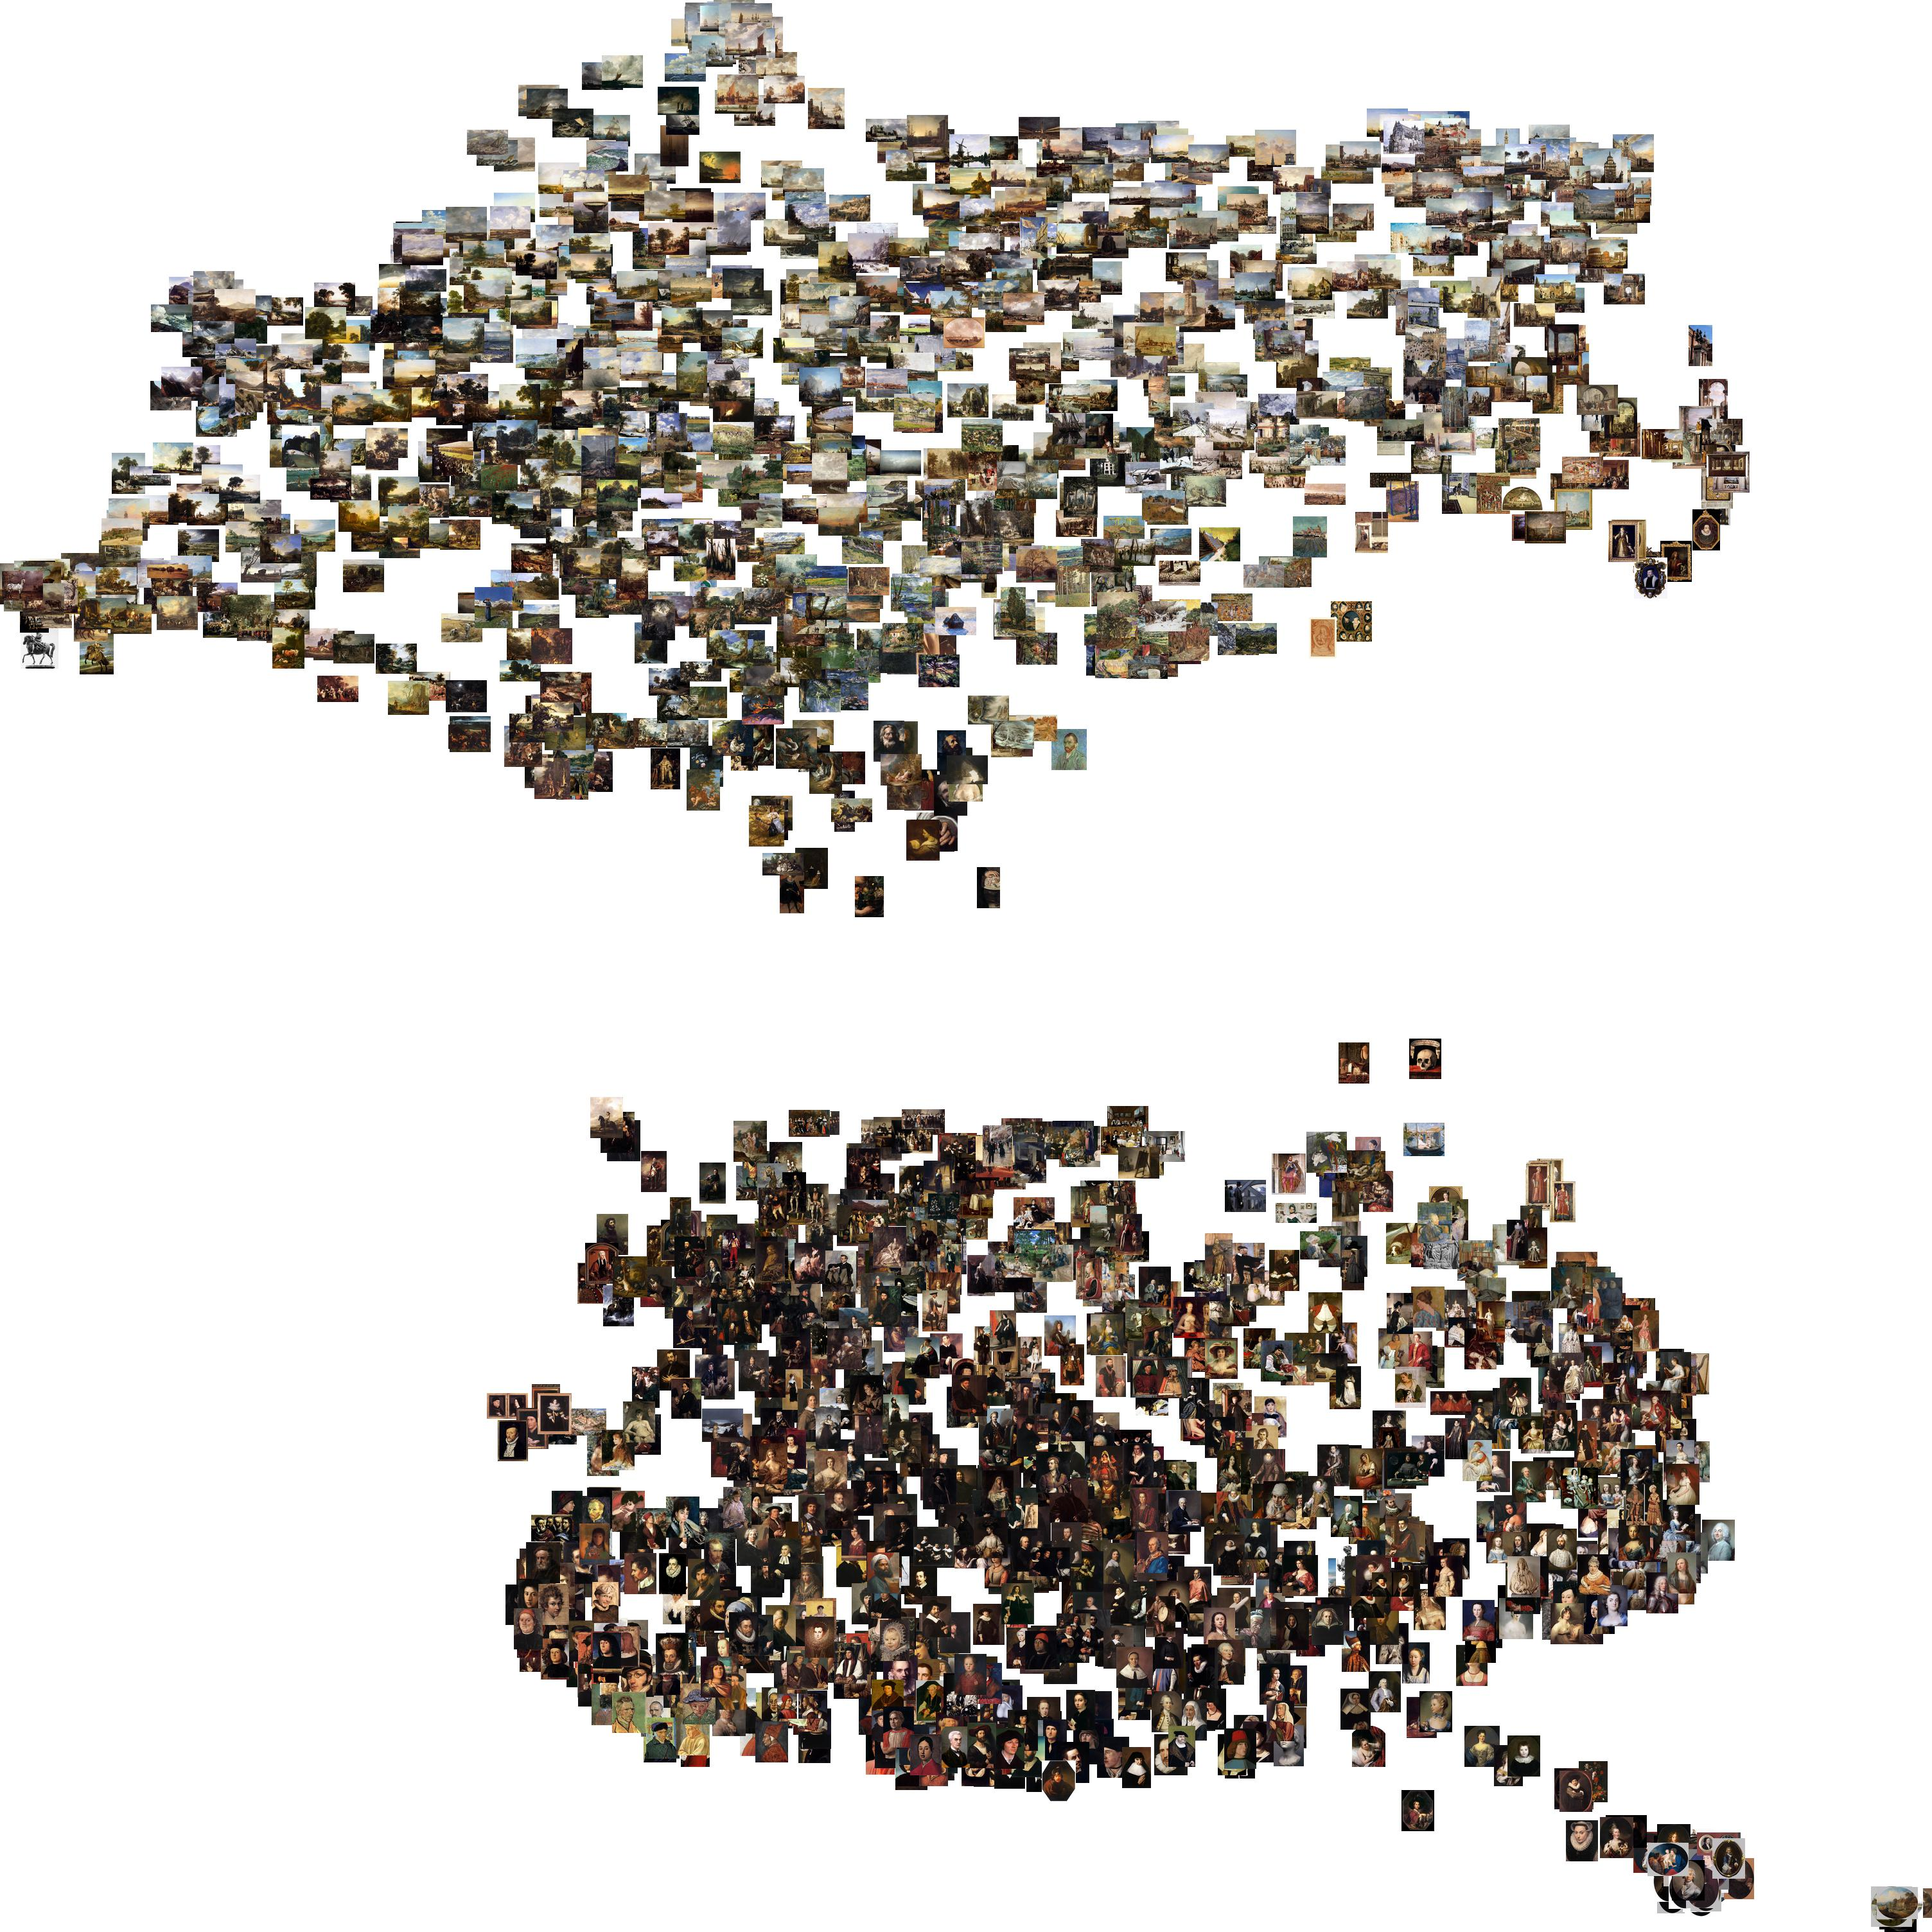

In [10]:
# UMAP only
plot, _ = plot_features(img_files, features_UMAP, thumb_size=64)
show_img(plot)

## On and off the grid...

To see all the thumbnails, we want to order everything neatly in a grid, but without loosing the clustering. For this *linear assignment problem* we need a *linear assignment problem solver*. We will use the so called Jonker-Volgenant algorithm.

Grid size: 46x46, samples: 2116
Canvas size: 3008


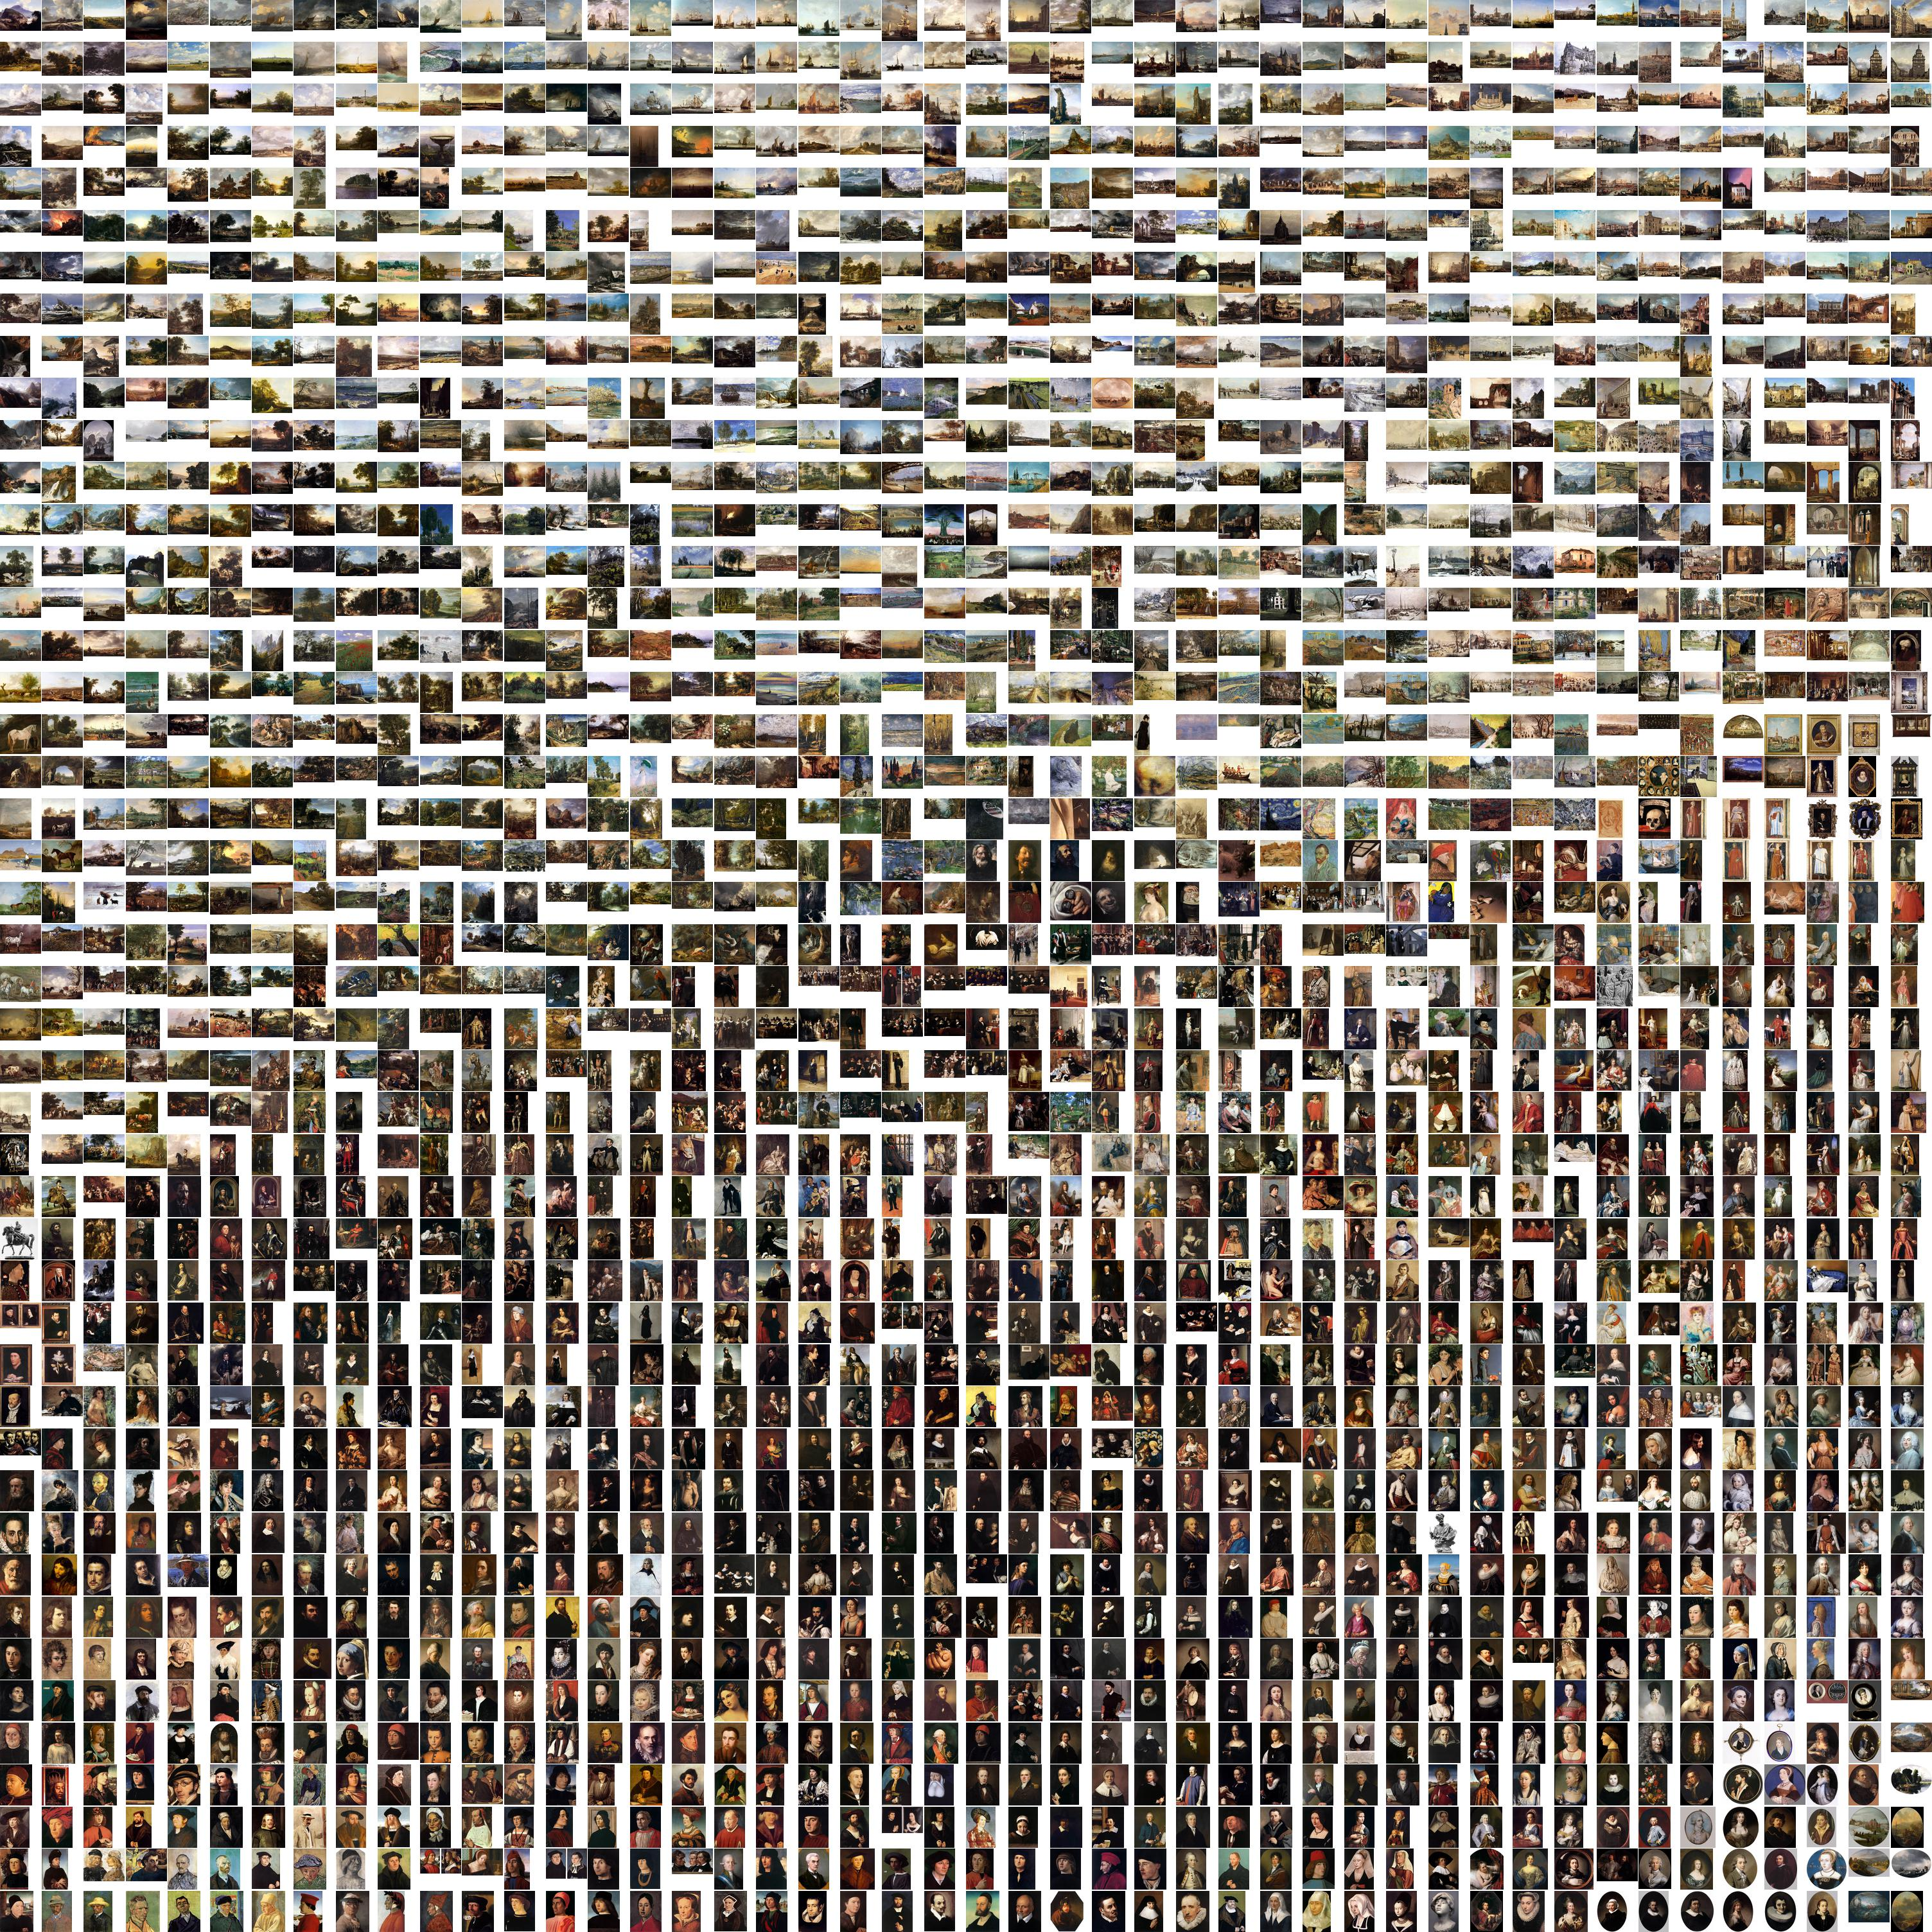

In [14]:
# UMAP + LAP
import importlib
features_lapjv, img_files_lapjv = umap_to_lapjv(img_files, features_UMAP, thumb_size=64)
plot, html_map = plot_features(img_files_lapjv, features_lapjv, thumb_size=64)
show_img(plot)

In [13]:
# HTML Template
html_template = \
"""
<!DOCTYPE html>
<html lang="en">
  <head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
  </head>
  <body>
    <img src="%s" usemap="#ImageMap">
    <map name="ImageMap">
      %s
    </map>
  </body>
</html>
"""

# Write HTML map file
save_img(plot, 'plot.jpg')
html_map_string = '\n'.join(html_map[::-1]) # Reverse list so last plotted images take precedence as links
with open('map.html', 'w') as f: 
    f.write(html_template % ('plot.jpg', html_map_string))

## <font color='red'>Exercises</font>

Explore your own dataset. Play with the visualization parameters. Experiment with the feature extractor - would it be useful to use a different/differently trained network, or a different layer?